In [15]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load pickle file with results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

cm = {}
fi = {}
roc = {}


# Print the results
for dataset, models in results.items():
    print(f"Dataset: {dataset}")
    approach = dataset.split('_')[0]
    dataset_name = "_".join(dataset.split('_')[1:])
    X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_name}/X_test.csv")
    y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_name}/y_test.csv")

    for model_name, model_results in models.items():
        print(f"  Model: {model_name}")
        y_pred = model_results['fitted_model'].predict(X_test)
        
        # Confusion matrix
        cm[(dataset,model_name)] = confusion_matrix(y_test, y_pred)
        

        # Feature importance
        if hasattr(model_results['fitted_model'], 'feature_importances_'):
                fi[(dataset,model_name)] = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': model_results['fitted_model'].feature_importances_
                }).sort_values(by='Importance', ascending=False)
        elif hasattr(model_results['fitted_model'], 'coef_'):
            fi[(dataset,model_name)] = pd.DataFrame({
                'Feature': X_test.columns,
                'Importance': np.abs(model_results['fitted_model'].coef_[0])
            }).sort_values(by='Importance', ascending=False)
        else:
            fi[(dataset, model_name)] = None


Dataset: Initial_real_data
  Model: Random Forest
  Model: GradientBoosting
  Model: XGBoost
  Model: $k$NN
  Model: LGBM
Dataset: Initial_synth_data
  Model: Random Forest
  Model: GradientBoosting
  Model: XGBoost
  Model: $k$NN
  Model: LGBM
Dataset: Extra_real_data
  Model: Random Forest
  Model: GradientBoosting
  Model: XGBoost
  Model: $k$NN
  Model: LGBM
Dataset: Extra_real_pseudoreal_data
  Model: Random Forest
  Model: GradientBoosting
  Model: XGBoost
  Model: $k$NN
  Model: LGBM
Dataset: Extra_real_pseudoreal_synth_data
  Model: Random Forest
  Model: GradientBoosting
  Model: XGBoost
  Model: $k$NN
  Model: LGBM


In [21]:
# Plot confusion matrices
for (dataset, model_name), cm_df in cm.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} on {dataset}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'items'

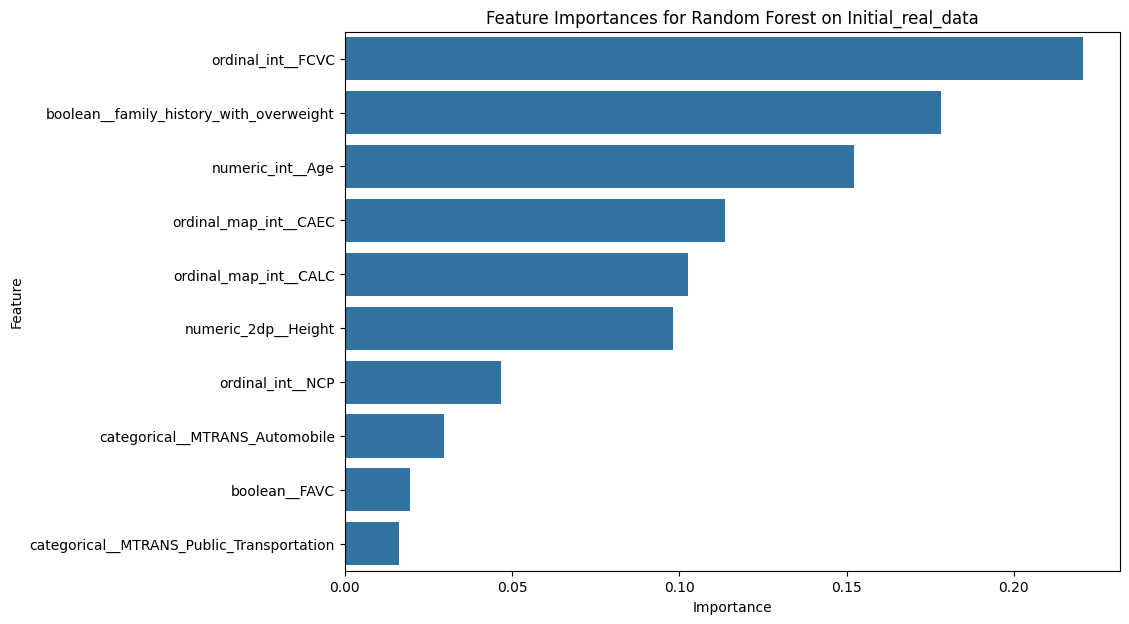

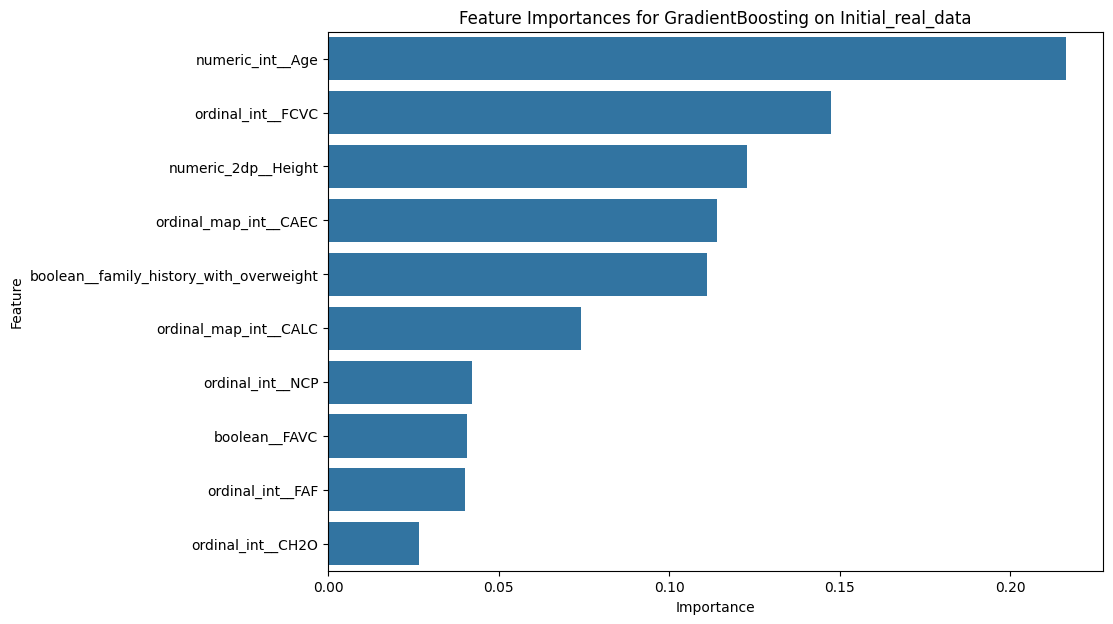

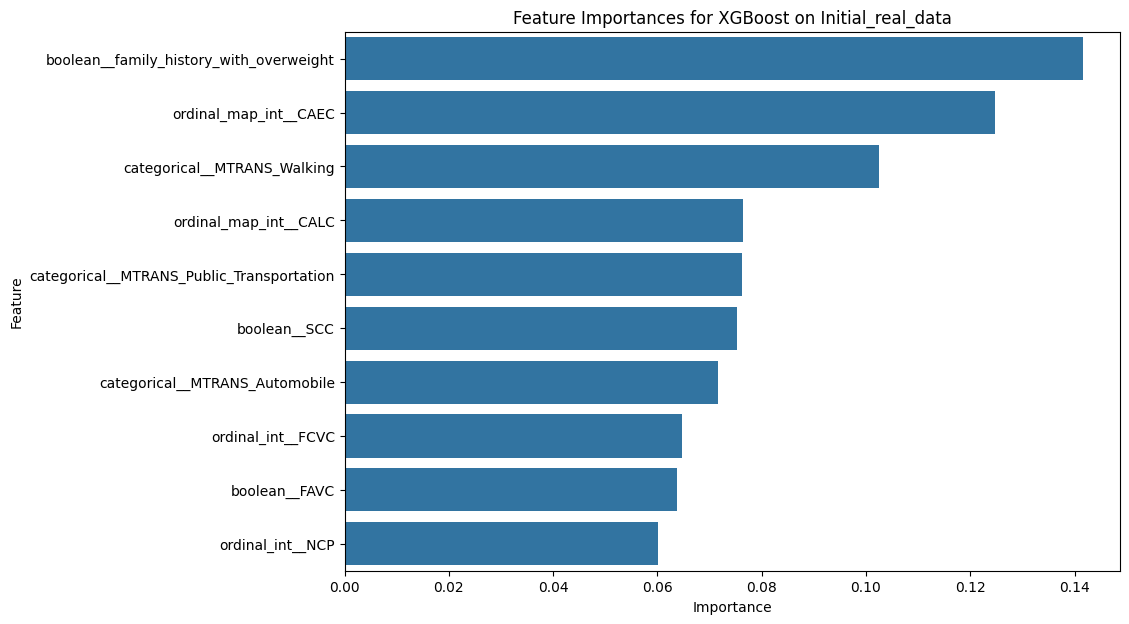

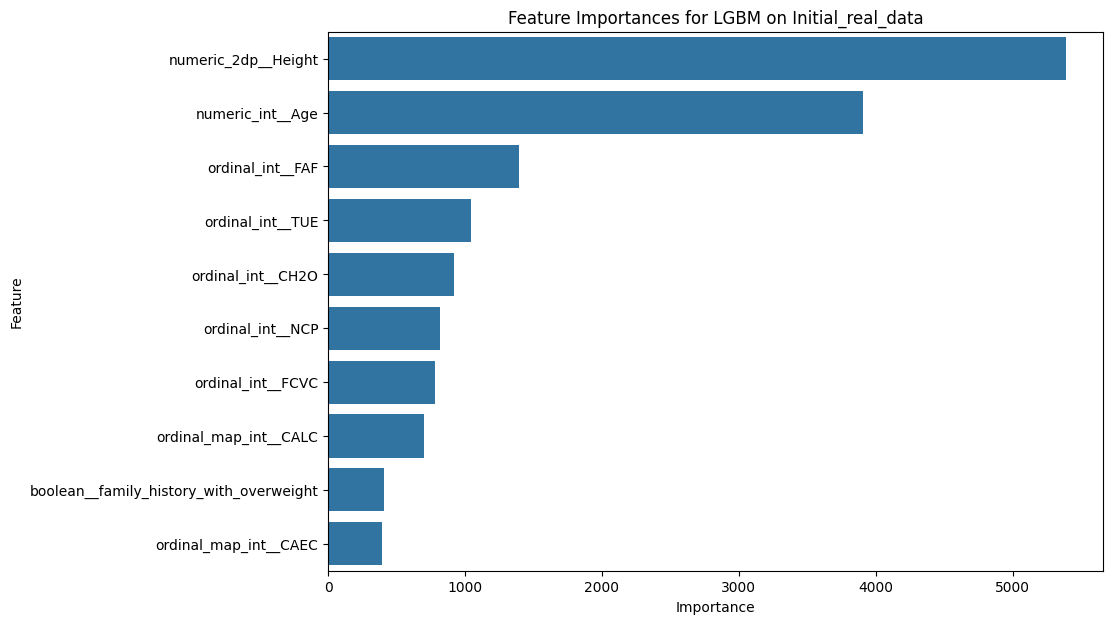

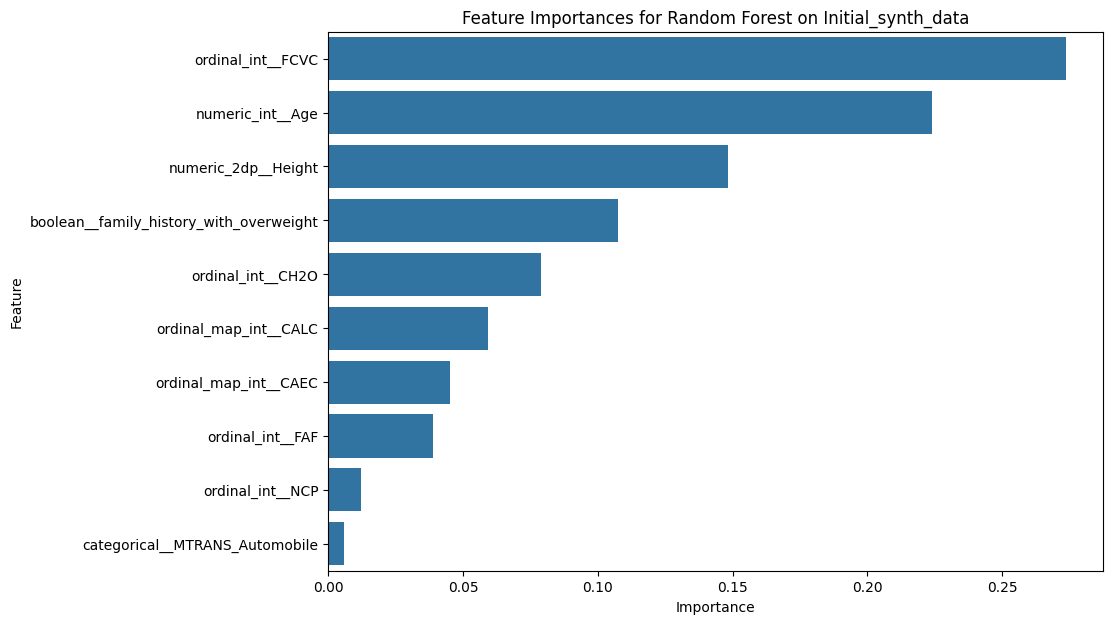

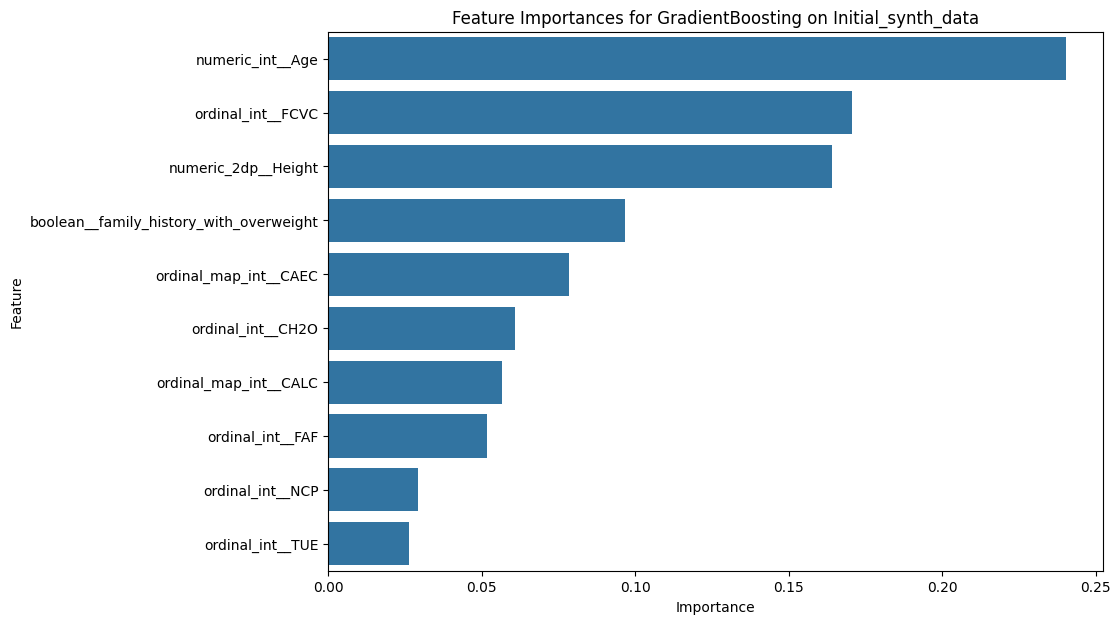

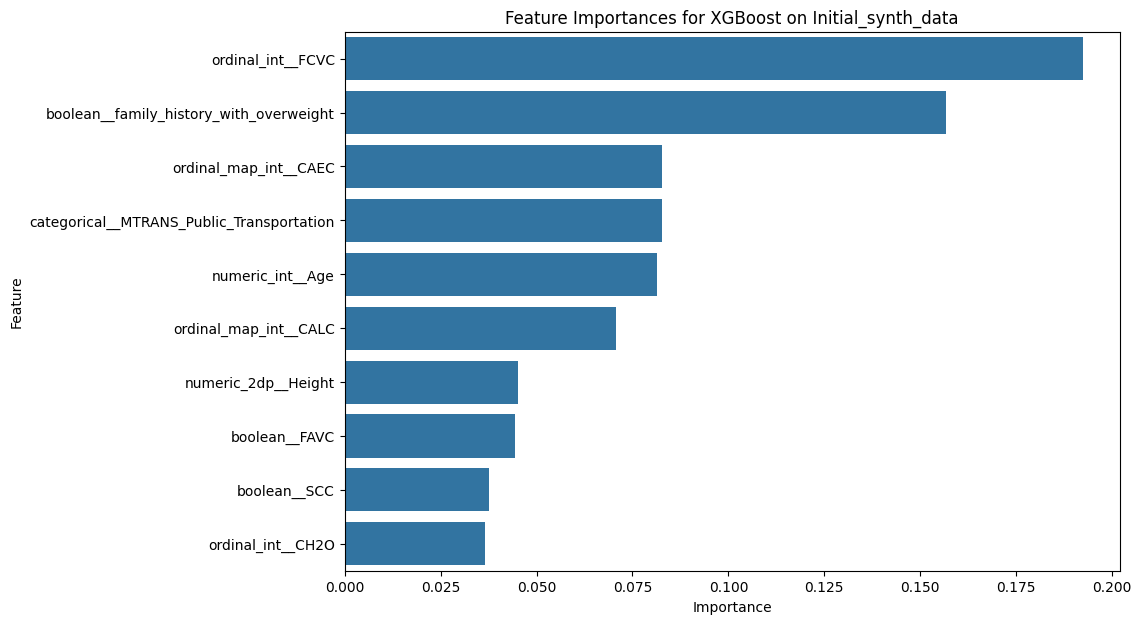

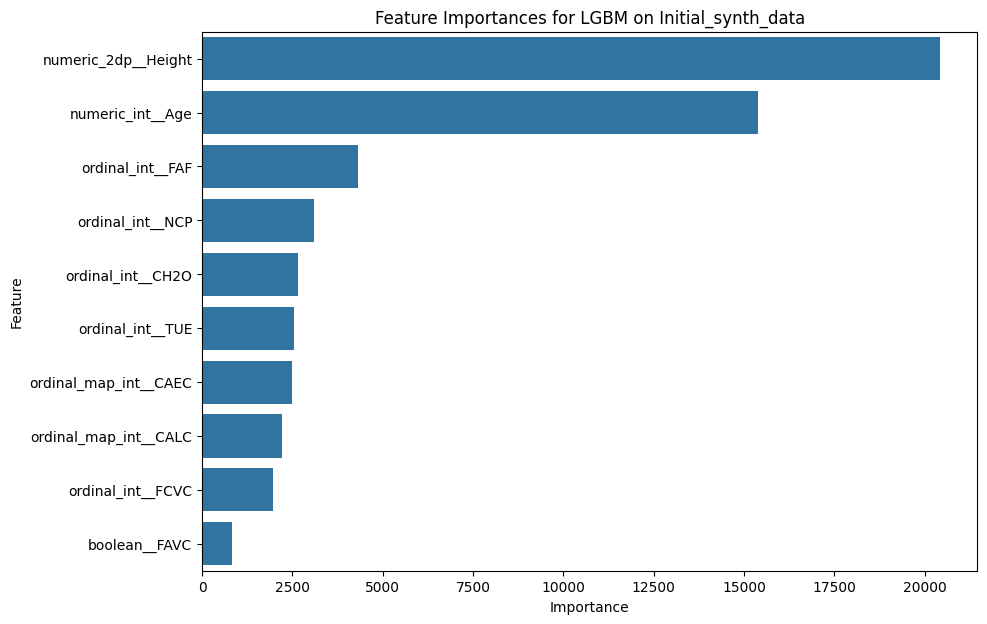

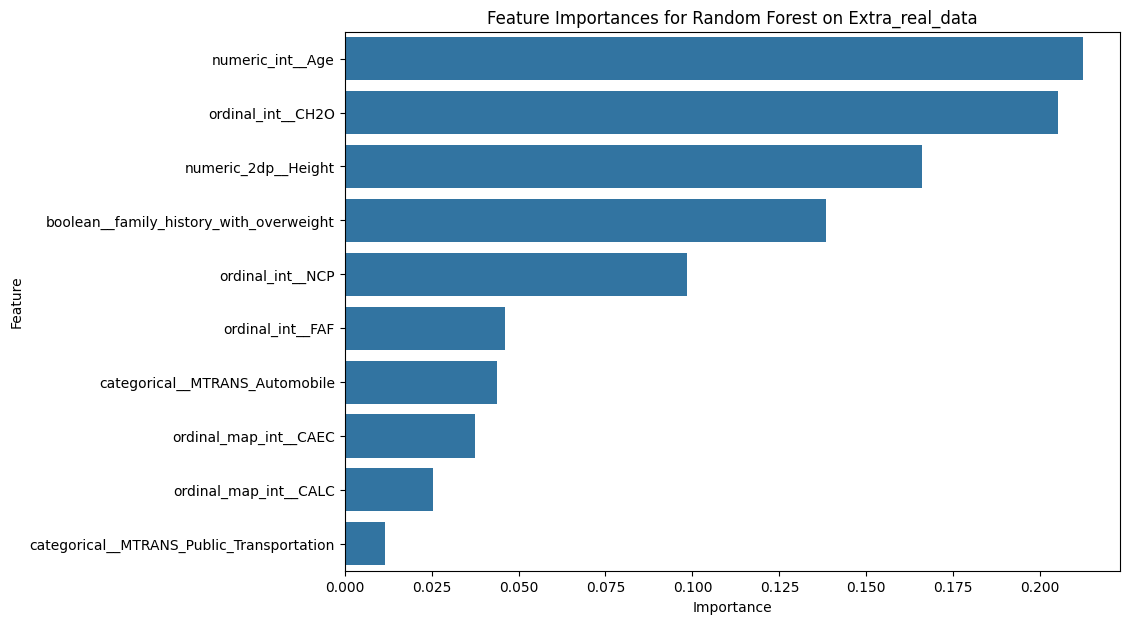

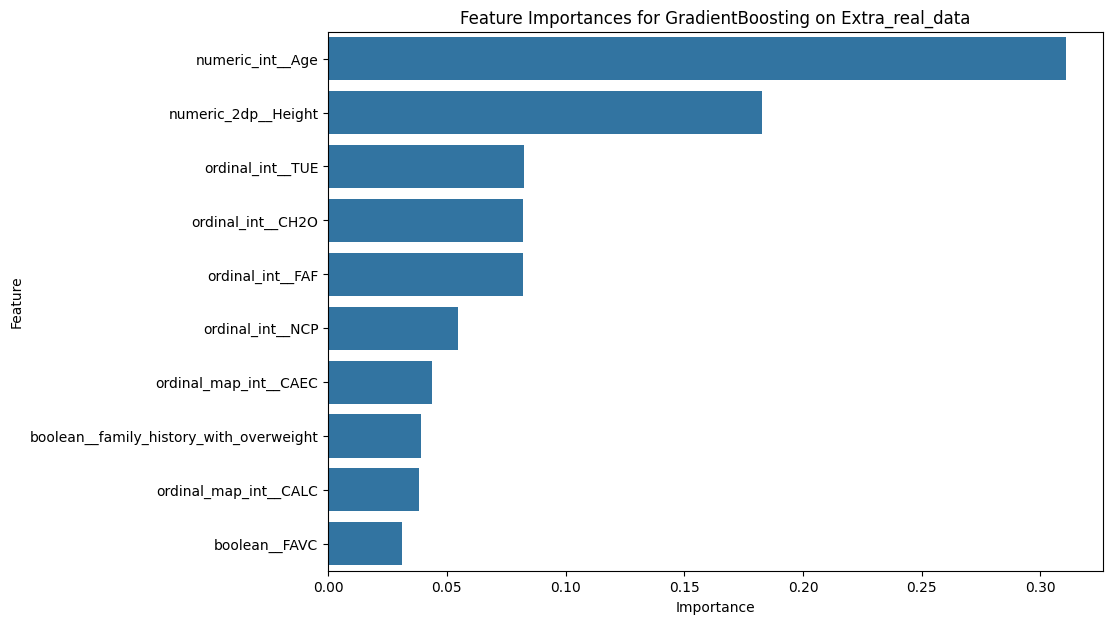

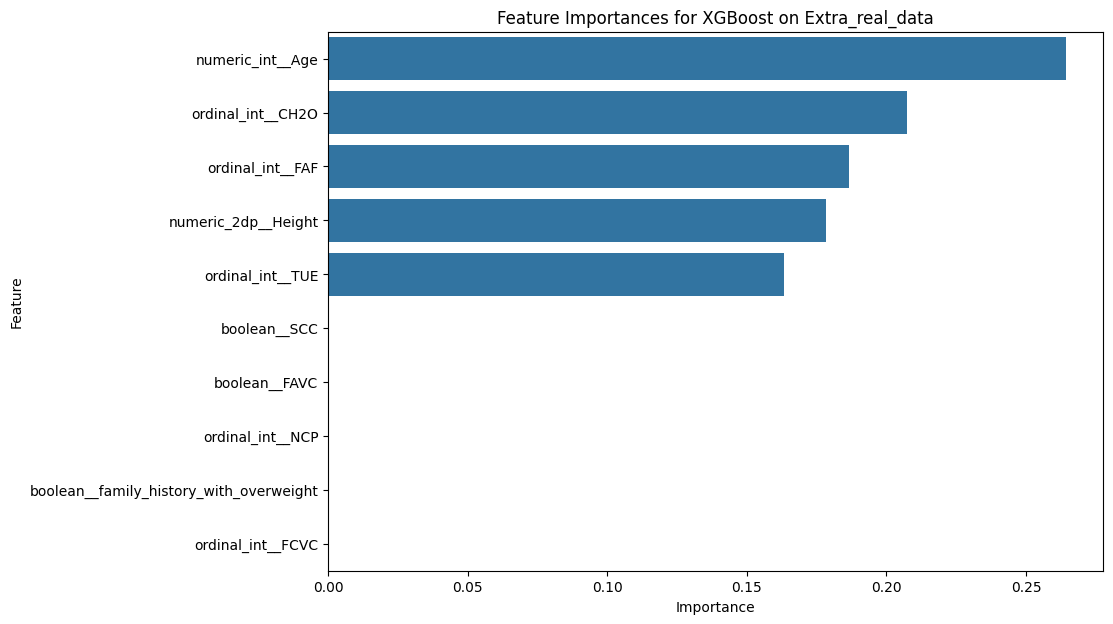

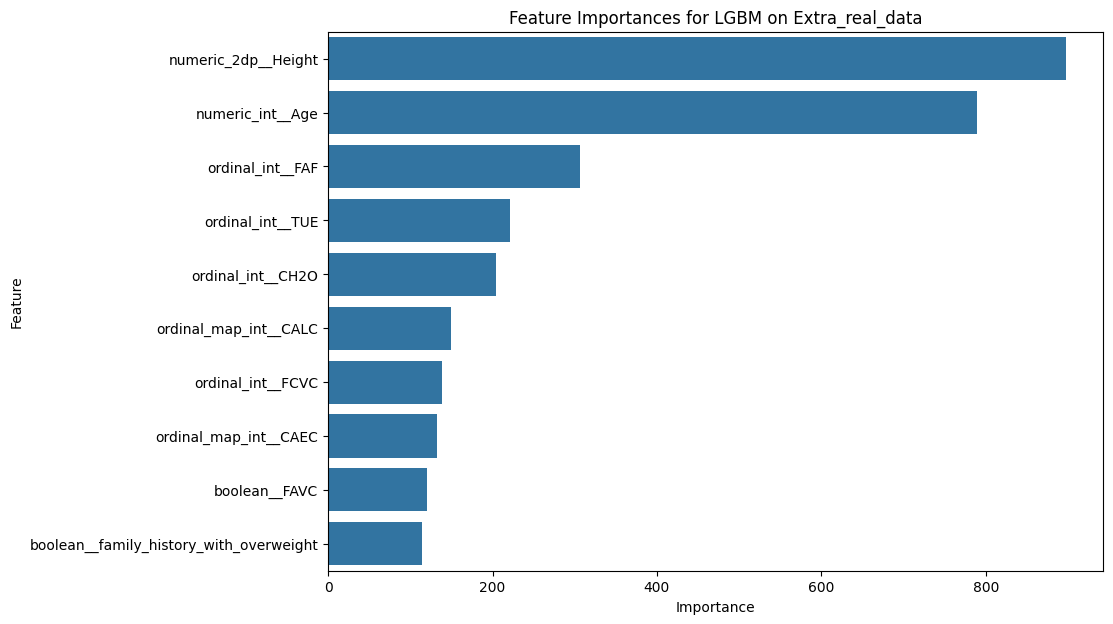

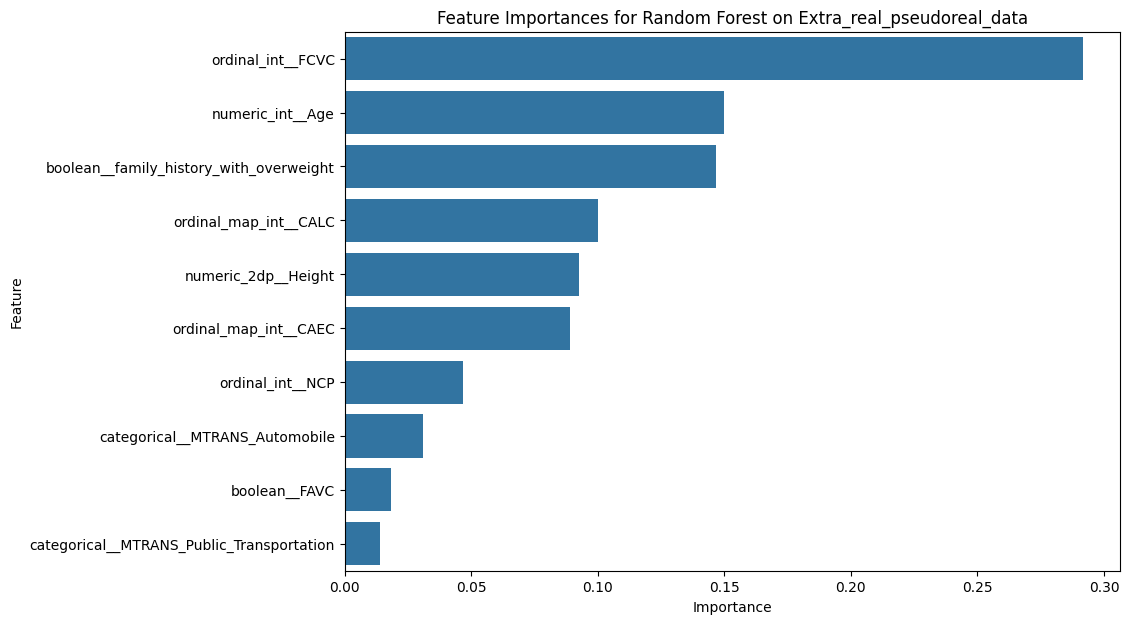

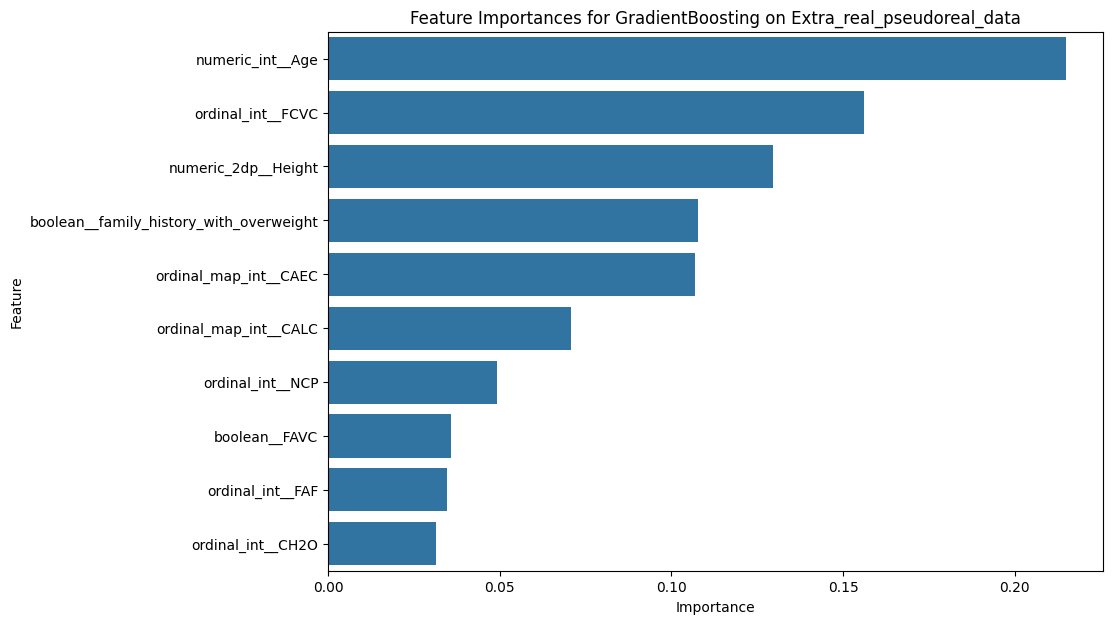

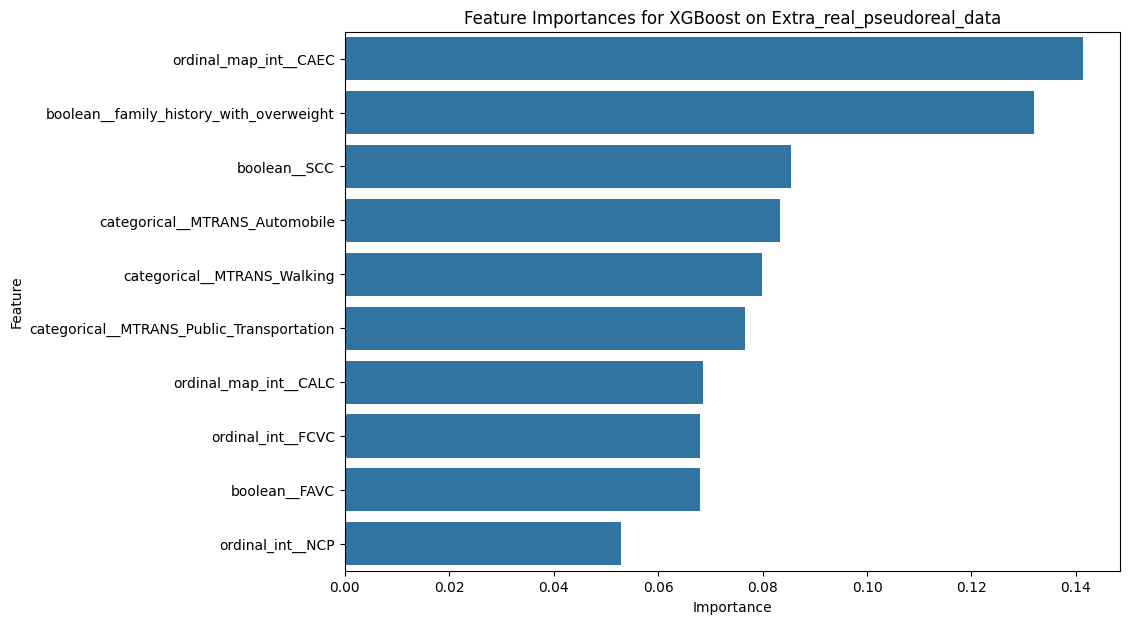

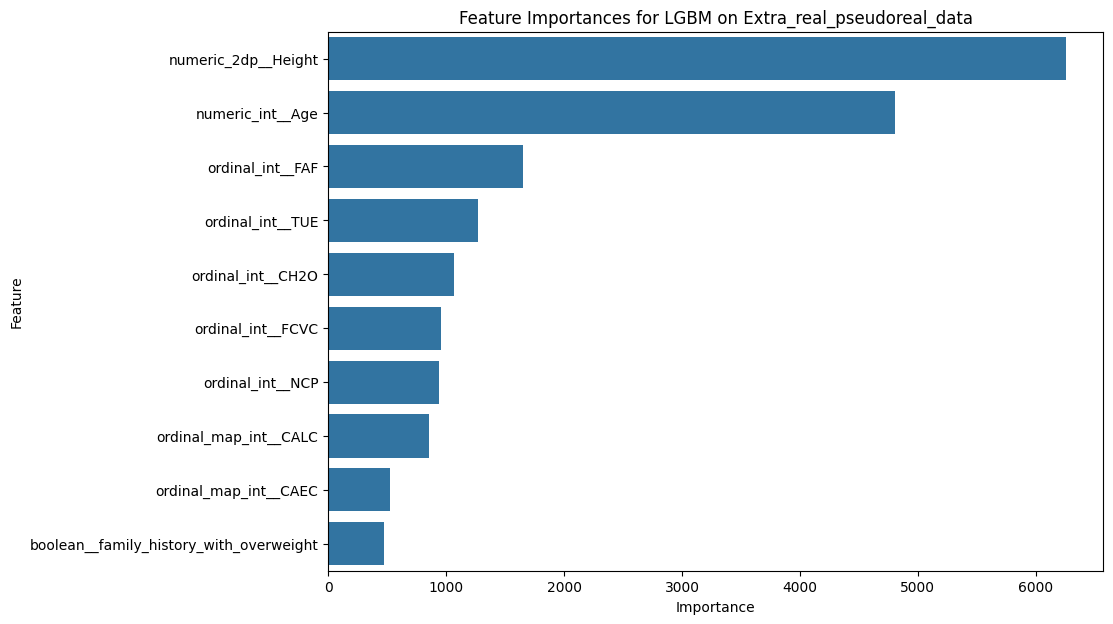

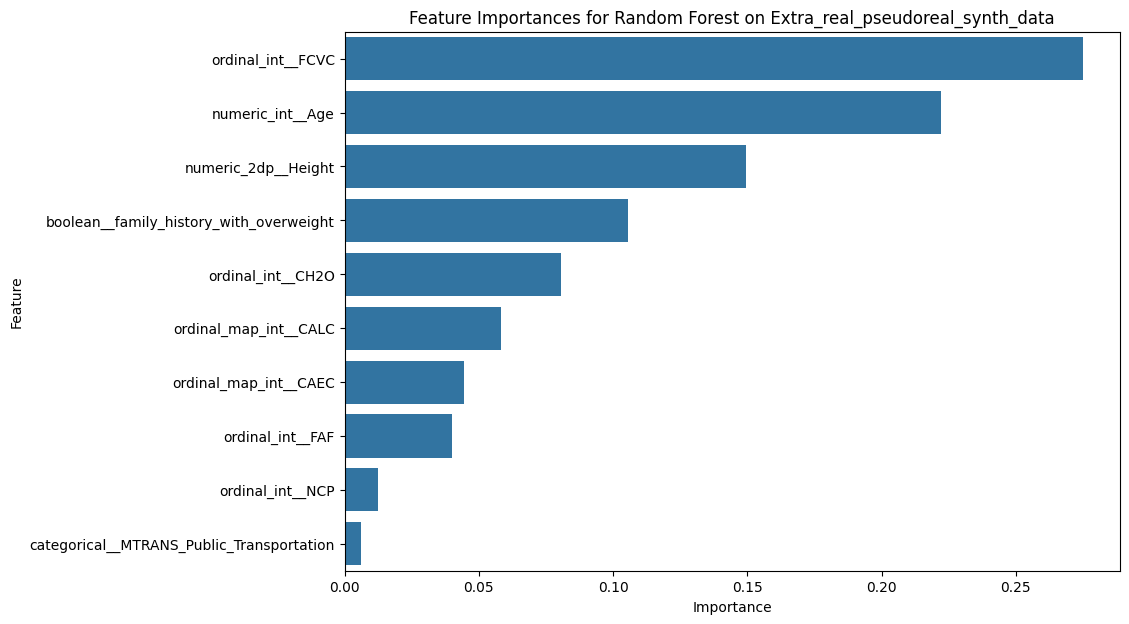

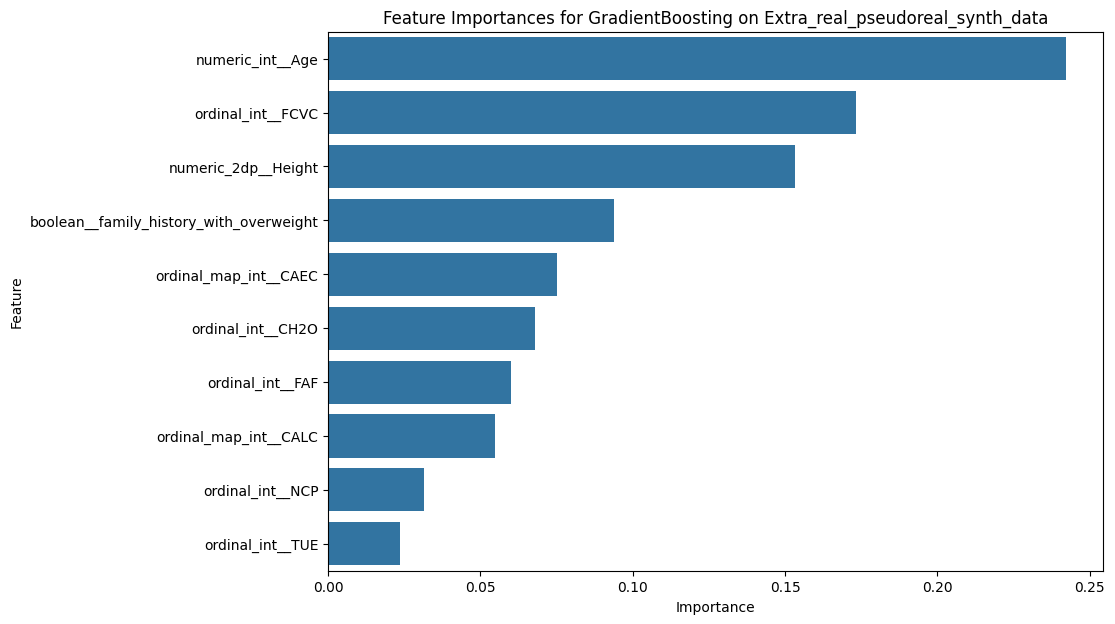

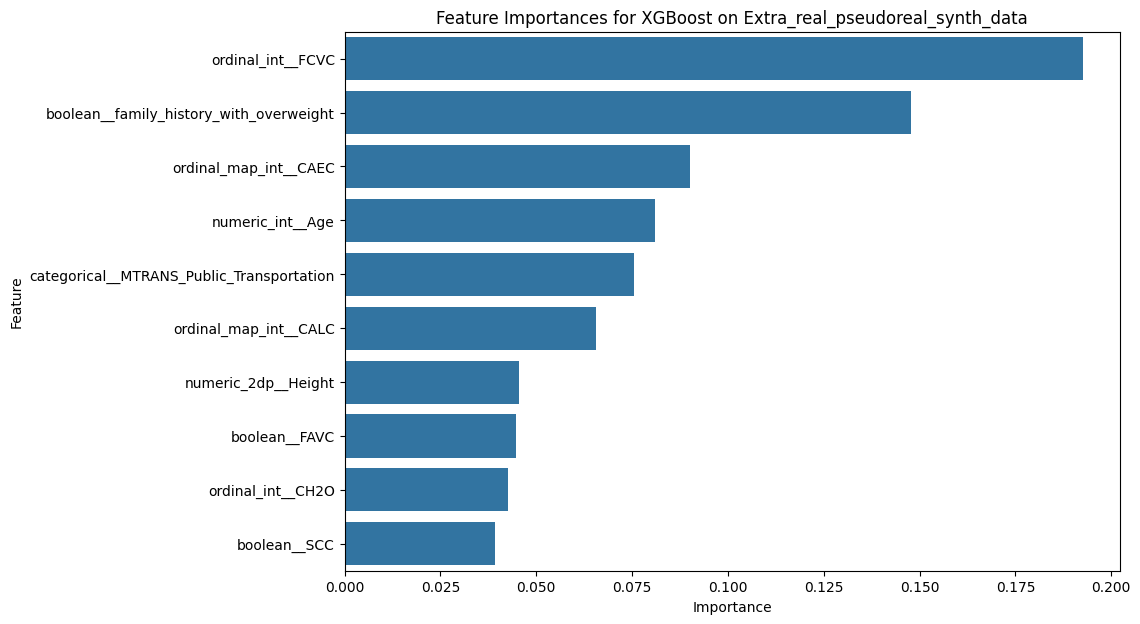

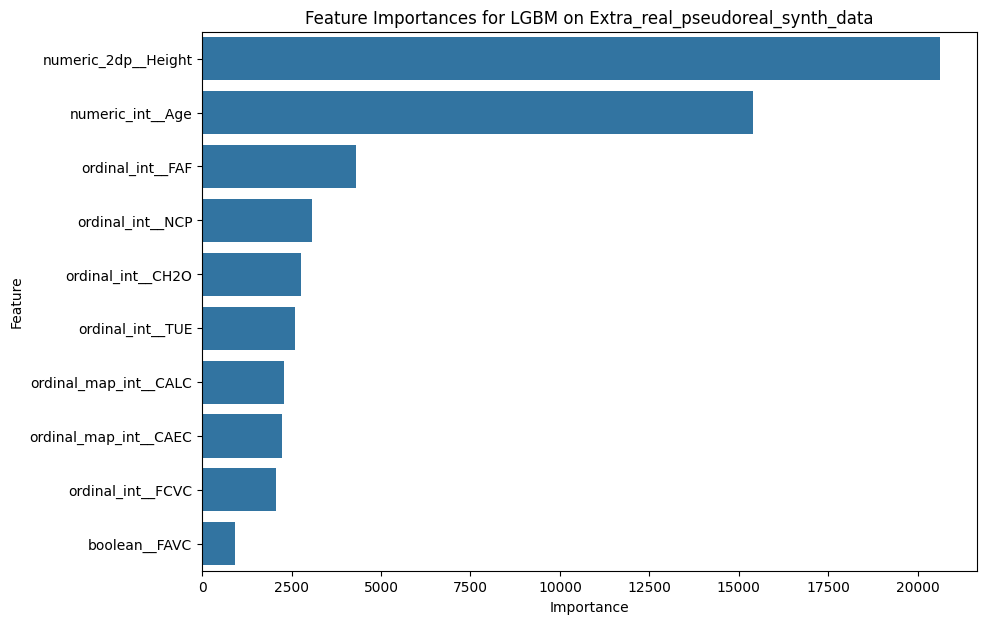

In [23]:
# Feature importance plots
# Plot the feature importances
for (dataset, model_name), fi_df in fi.items():
    if fi_df is not None:
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Importance', y='Feature', data=fi_df.head(10))
        plt.title(f"Feature Importances for {model_name} on {dataset}")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

In [25]:
# Classification report
for dataset, models in results.items():
    print(f"Dataset: {dataset}")
    for model_name, model_results in models.items():
        y_pred = model_results['fitted_model'].predict(X_test)
        print(f"  Model: {model_name}")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("\n")

Dataset: Initial_real_data
  Model: Random Forest
              precision    recall  f1-score   support

           0       0.17      0.71      0.28         7
           1       0.65      0.36      0.47        55
           2       0.11      0.22      0.14         9
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11

    accuracy                           0.28        96
   macro avg       0.13      0.19      0.13        96
weighted avg       0.39      0.28      0.30        96



  Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.19      0.71      0.29         7
           1       0.64      0.38      0.48        55
           2       0.11      0.11      0.11         9
           3       0.14      0.50      0.22         2
           4       0.00      0.00      0.00         1
